In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import shapely.wkt
import shapely.geometry
import pandas as pd
import shapely.geometry.multipolygon as sh

In [2]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_18948\346630003.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  min_lon = thailandmap.unary_union.bounds[0]
C:\Users\595078\AppData\Local\Temp\ipykernel_18948\346630003.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  max_lon = thailandmap.unary_union.bounds[2]
C:\Users\595078\AppData\Local\Temp\ipykernel_18948\346630003.py:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.


Data variables:
    SI_Solar   (lat, lon) float64 128MB ...
    SI_Wind    (lat, lon) float64 128MB ...
    ADM1_EN    (lat, lon) <U24 2GB ...
    A_BGEC     (lat, lon) float64 128MB ...
    A_Biomass  (lat, lon) float64 128MB ...
    A_BGWW     (lat, lon) float64 128MB ...
    A_MSW      (lat, lon) float64 128MB ...
    A_IEW      (lat, lon) float64 128MB ...
    AVA_Wind   (lat, lon) float32 64MB ...
    AVA_Solar  (lat, lon) float32 64MB ...


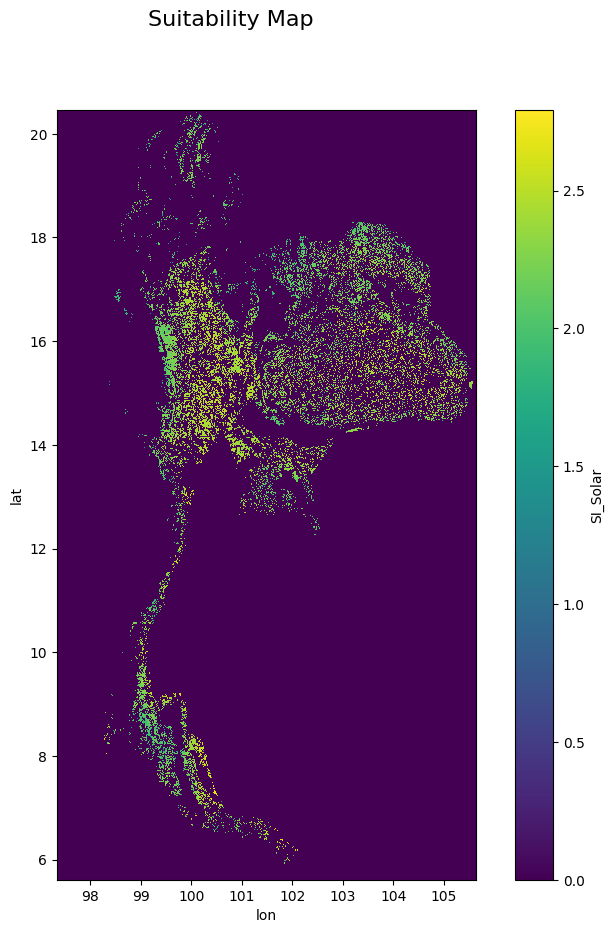

In [3]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_final_SI.nc')
print(xr_landuse_suitability_index.data_vars)
fig, ax = plt.subplots(figsize=(10,10))
title = 'Suitability Map'
type = 'SI_Solar' 
fig.suptitle(str(title), fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_landuse_suitability_index[type].plot(ax = ax,zorder = 1)

In [4]:
######### Next I assign Region to xarray ################################################################################
region = pd.read_csv('Data\\Region.csv',index_col=False)
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
list_region = []
count = 0
for i in thailandmap['ADM1_TH']:
    r = region['region'].loc[region['province'] == i]
    try : 
        # print(i,r.values[0])
        list_region.append(r.values[0])
    except :
        print(i,'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        list_region.append('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
thailandmap['region'] = list_region
thailandmap['center'] = thailandmap['geometry'].centroid
thailandmap = thailandmap.set_geometry('center')
thailandmap = thailandmap.drop(columns=['Shape_Leng',
                                        'Shape_Area',
                                        'ADM1_PCODE',
                                        'ADM1_REF',
                                        'ADM1ALT1EN',
                                        'ADM1ALT2EN',
                                        'ADM1ALT1TH',
                                        'ADM1ALT2TH',
                                        'ADM0_EN',
                                        'ADM0_TH',
                                        'ADM0_PCODE',
                                        'date',
                                        'validOn',
                                        'validTo'
                                        ,'geometry'
                                        ])
df_final_SI = xr_landuse_suitability_index.to_dataframe()
df_final_SI.reset_index(inplace=True)
df_final_SI = gpd.GeoDataFrame(df_final_SI, geometry =gpd.points_from_xy(df_final_SI['lon'],df_final_SI['lat']))
df_final_SI.crs = {'init': 'epsg:4326'}
df_final_SI.reset_index(inplace= True, drop = False)
df_final_SI_2 = gpd.sjoin_nearest(df_final_SI,thailandmap,how = 'left')
df_final_SI_2 = df_final_SI_2.drop(columns=['ADM1_TH','geometry','index_right'])
df_final_SI_2 = df_final_SI_2.drop_duplicates('index')
df_final_SI_2 = df_final_SI_2.drop(columns=['index'])
df_final_SI_2.reset_index(inplace= True, drop = True)
df_final_SI_2 = df_final_SI_2.set_index(['lat', 'lon'])
xr_landuse_suitability_index = xr.Dataset.from_dataframe(df_final_SI_2)
#########################################################################################

d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\595078\AppData\Local\Temp\ipykernel_18948\4206441180.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  thailandmap['center'] = thailandmap['geometry'].centroid
d:\workstation\REPowerPlant_Siting\env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.gith

In [5]:
print(xr_landuse_suitability_index)

<xarray.Dataset> Size: 1GB
Dimensions:        (lat: 5346, lon: 2985)
Coordinates:
  * lat            (lat) float64 43kB 5.615 5.618 5.621 ... 20.46 20.46 20.46
  * lon            (lon) float64 24kB 97.35 97.35 97.35 ... 105.6 105.6 105.6
Data variables:
    SI_Solar       (lat, lon) float64 128MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SI_Wind        (lat, lon) float64 128MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ADM1_EN_left   (lat, lon) object 128MB 'Phuket' 'Phuket' ... 'Bueng Kan'
    A_BGEC         (lat, lon) float64 128MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    A_Biomass      (lat, lon) float64 128MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    A_BGWW         (lat, lon) float64 128MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    A_MSW          (lat, lon) float64 128MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    A_IEW          (lat, lon) float64 128MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AVA_Wind       (lat, lon) float32 64MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    AVA_Solar      (lat, lon) 

In [6]:
print('AVA_Solar')
total = xr_landuse_suitability_index['AVA_Solar'].sum().values
print('total =', total)
for r in ['R0','R1','R2','R3','R4']:
    print(r, xr_landuse_suitability_index['AVA_Solar'].where(xr_landuse_suitability_index['region'] == r).sum().values,xr_landuse_suitability_index['AVA_Solar'].where(xr_landuse_suitability_index['region'] == r).sum().values *100/ total)


print('AVA_Wind')
total = xr_landuse_suitability_index['AVA_Wind'].sum().values
print('total =', total)
for r in ['R0','R1','R2','R3','R4']:
    print(r, xr_landuse_suitability_index['AVA_Wind'].where(xr_landuse_suitability_index['region'] == r).sum().values,xr_landuse_suitability_index['AVA_Wind'].where(xr_landuse_suitability_index['region'] == r).sum().values *100/ total)

AVA_Solar
total = 82200.88
R0 382.14005 0.4648855731120018
R1 17254.344 20.990460393664037
R2 34771.05 42.300094100646916
R3 10845.991 13.194494803270151
R4 18947.238 23.049920673563324
AVA_Wind
total = 78108.445
R0 346.59 0.4437292215345432
R1 16182.089 20.717463780575105
R2 33091.457 42.36604236437701
R3 11397.421 14.591790750460023
R4 17090.908 21.880999083705838


In [7]:
test = xr_landuse_suitability_index.to_dataframe()
print('SI_Solar')
for r in ['R0','R1','R2','R3','R4']:
    print(r,test['SI_Solar'].loc[(test['SI_Solar'] > 0) & (test['region'] == r)].mean())

print('SI_Wind')
for r in ['R0','R1','R2','R3','R4']:
    print(r,test['SI_Wind'].loc[(test['SI_Wind'] > 0) & (test['region'] == r)].mean())



SI_Solar
R0 2.4254022585898936
R1 2.316108477583422
R2 2.2405866607624465
R3 2.21622484440683
R4 2.257800366841216
SI_Wind
R0 1.730121941305352
R1 1.6430191844547084
R2 1.4602510574479173
R3 1.6581335016587122
R4 1.4979287991636163


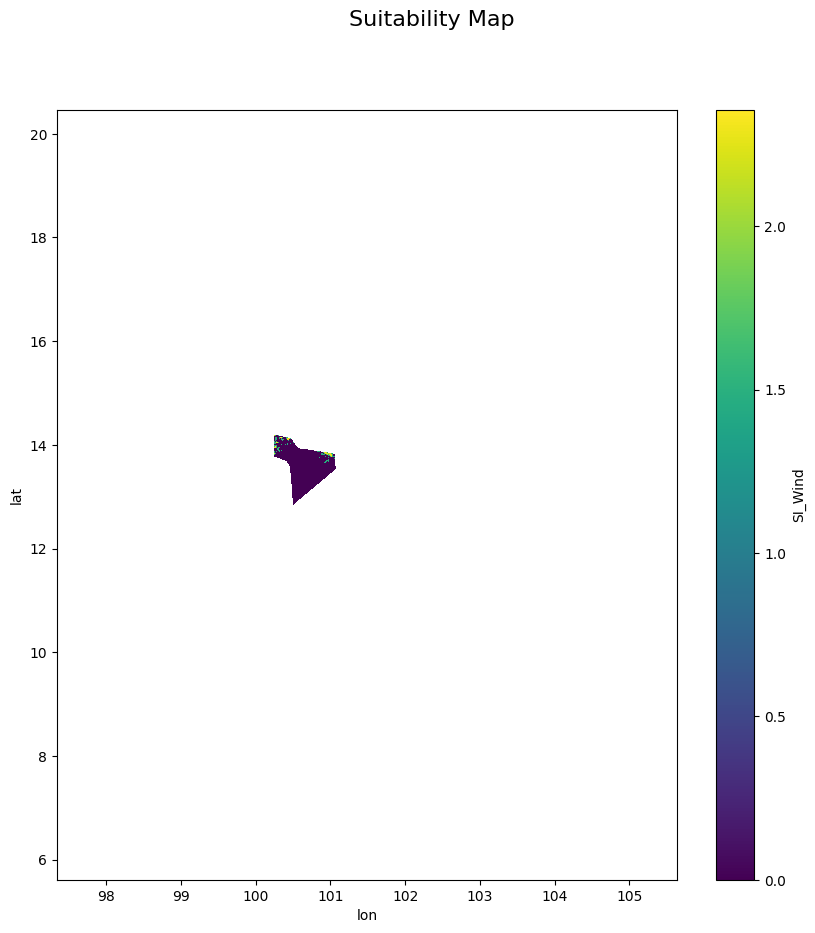

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
title = 'Suitability Map'
type = 'SI_Wind' 
fig.suptitle(str(title), fontsize=16)
xr_landuse_suitability_index[type].where(xr_landuse_suitability_index['region'] == 'R0').plot(ax = ax,zorder = 1)

In [9]:
# fig, ax = plt.subplots(figsize=(10,10))
# plt.hist(xr_landuse_suitability_index[type].where(xr_landuse_suitability_index[type]>0),histtype ='barstacked',bins=12)
